# Машинное обучение, ФКН ВШЭ

## Практическое задание 6. Разложение ошибки на смещение и разброс

### Общая информация

Дата выдачи: 20.11.2020

Мягкий дедлайн: 00:59MSK 02.12.2019

Жесткий дедлайн: 00:59MSK 07.12.2019

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-06-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

В этом задании вам предстоит воспользоваться возможностями бутстрапа для оценки смещения и разброса алгоритмов машинного обучения. Делать мы это будем на данных boston:

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from tqdm import tqdm
from sklearn.ensemble import GradientBoostingRegressor
import copy
import math
%matplotlib inline

In [ ]:
from sklearn.datasets import load_boston

In [ ]:
boston = load_boston()

In [ ]:
X = boston["data"]
y = boston["target"]

In [ ]:
X.shape, y.shape

((506, 13), (506,))

In [ ]:
X

array([[6.3200e-03, 1.8000e+01, 2.3100e+00, ..., 1.5300e+01, 3.9690e+02,
        4.9800e+00],
       [2.7310e-02, 0.0000e+00, 7.0700e+00, ..., 1.7800e+01, 3.9690e+02,
        9.1400e+00],
       [2.7290e-02, 0.0000e+00, 7.0700e+00, ..., 1.7800e+01, 3.9283e+02,
        4.0300e+00],
       ...,
       [6.0760e-02, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9690e+02,
        5.6400e+00],
       [1.0959e-01, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9345e+02,
        6.4800e+00],
       [4.7410e-02, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9690e+02,
        7.8800e+00]])

In [ ]:
y

### Вычисление bias и variance с помощью бутстрапа
На лекции была выведено следующая формула, показывающая, как можно представить ошибку алгоритма регрессии в виде суммы трех компонент:
$$
L(\mu) = 
    \mathbb{E}_{x, y}\bigl[\mathbb{E}_{X}\bigl[ (y - \mu(X)(x))^2 \bigr]\bigr] = 
$$
$$
    \underbrace{\mathbb{E}_{x, y}\bigl[(y - \mathbb{E}[y|x] )^2\bigr]}_{\text{шум}} + \underbrace{\mathbb{E}_{x}\bigl[(\mathbb{E}_{X}[\mu(X)(x)] - \mathbb{E}[y|x] )^2\bigr]}_{\text{смещение}} +
    \underbrace{\mathbb{E}_{x}\bigl[\mathbb{E}_{X}\bigl[(\mu(X)(x) - \mathbb{E}_{X}[\mu(X)(x)] )^2\bigr]\bigr]}_{\text{разброс}},
$$
* $\mu(X)$ — алгоритм, обученный по выборке $X = \{(x_1, y_1), \dots (x_\ell, y_\ell)\}$;
* $\mu(X)(x)$ — ответ алгоритма, обученного по выборке $X$, на объекте $x$;
* $\mathbb{E}_{X}$ — мат. ожидание по всем возможным выборкам;
* $\mathbb{E}_{X}[\mu(X)(x)]$ — "средний" ответ алгоритма, обученного по всем возможным выборкам $X$, на объекте $x$.
    
С помощью этой формулы мы можем анализировать свойства алгоритма обучения модели $\mu$, если зададим вероятностную модель порождения пар $p(x, y)$.

В реальных задачах мы, конечно же, не знаем распределение на парах объект - правильный ответ. Однако у нас есть набор семплов из этого распределения (обучающую выборка), и мы можем использовать его, чтобы оценивать математические ожидания. Для оценки мат. ожиданий по выборкам мы будем пользоваться бутстрэпом - методом генерации "новых" выборок из одной с помощью выбора объектов с возвращением. Разберем несколько шагов на пути к оценке смещения и разброса.

#### Приближенное вычисление интегралов
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar z} f(\bar z)$ функции от многомерной случайной величины $\bar z = (z_1, \dots, z_d)$, $\bar z \sim p(\bar z)$, можно сгенерировать выборку из распределения $p(\bar z)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar z} f(z) = \int f(\bar z) p(\bar z) d \bar z \approx \frac 1 m \sum_{i=1}^m f(\bar z_i), \, \bar z_i \sim p(\bar z), i = 1, \dots, m.$$

Например, оценим $\mathbb{E}_z z^2,$ $z \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_z z^2 = \sigma^2 + \mu^2 = 34$):

In [ ]:
z = np.random.normal(loc=5, scale=3, size=1000)
(z**2).mean()

35.07365202630074

#### Оценивание $\mathbb{E}_{x, y}$
Оценить мат. ожидания по $x$ и по $x, y$, встречающиеся во всех трех компонентах разложения, несложно, потому что у нас есть выборка объектов из распределения данных $p(x, y)$:
$$ \mathbb{E}_{x} f(x) \approx \frac 1 N \sum_{i=1}^N f(x_i), \quad
\mathbb{E}_{x, y} f(x, y) \approx \frac 1 N \sum_{i=1}^N f(x_i, y_i),$$
где $N$ - число объектов в выборке, $\{(x_i, y_i)\}_{i=1}^N$ - сама выборка. 

#### Оценивание $\mathbb{E}_X$ с помощью бутстрапа
Чтобы оценить мат. ожидание по $X$, нам понадобится выборка из выборок:
$$\mathbb{E}_X f(X) \approx \frac 1 s \sum_{j=1}^s f(X_j),$$
где $X_j$ - $j$-я выборка. Чтобы их получить, мы можем воспользоваться бутстрапом - методом генерации выборок на основе выбора объектов с возвращением. Чтобы составить одну выборку, будем $N$ раз выбирать индекс объекта $i \sim \text{Uniform}(1 \dots N)$ и добавлять $i$-ю пару (объект, целевая переменная) в выборку. В результате в каждой выборке могут появиться повторяющиеся объекты, а какие-то объекты могут вовсе не войти в некоторые выборки.

#### Итоговый алгоритм оценки смещения и разброса алгоритма $a$
1. Сгенерировать $s$ выборок $X_j$ методом бутстрапа.
1. На каждой выборке $X_j$ обучить алгоритм $a_j$.
1. Для каждой выборки $X_j$ определить множество объектов $T_j$, не вошедших в нее (out-of-bag). Вычислить предсказания алгоритма $a_j$ на объектах $T_j$. 

Поскольку у нас есть только один ответ для каждого объекта, мы будем считать шум равным 0, а $\mathbb{E}[y|x]$ равным имеющемуся правильному ответу для объекта $x$. 

Итоговые оценки:
* Смещение: для одного объекта - квадрат разности среднего предсказания и правильного ответа. Среднее предсказание берется только по тем алгоритмам $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего смещения выполнить усреденение смещений по объектам.
* Разброс: для одного объекта - выборочная дисперсия предсказаний алгоритмов $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего разброса выполнить усреденение разбросов по объектам.
* Ошибка $L$: усреднить квадраты разностей предсказания и правильного ответа по всем выполненным предсказаниям для всех объектов.

В результате должно получиться, что ошибка приблизительно равна сумме смещения и разброса!

Алгоритм также вкратце описан по [ссылке](https://web.engr.oregonstate.edu/~tgd/classes/534/slides/part9.pdf) (слайды 19-21).

__1. (3 балла)__

Реализуйте описанный алгоритм. Обратите внимание, что если объект не вошел ни в одну из out-of-bag выборок, учитывать его в вычислении итоговых величин не нужно. Как обычно, разрешается использовать только один цикл - по выборкам (от 0 до num_runs-1).

In [ ]:
def vec_mask_corresponder(vector, mask, func):
    return func(vector[mask])

vec_mask_vectorized = np.vectorize(vec_mask_corresponder, signature='(n),(n),()->()')


def compute_biase_variance(regressor, X, y, num_runs=1000, verbose=False):
    """
    :param regressor: sklearn estimator with fit(...) and predict(...) method
    :param X: numpy-array representing training set ob objects, shape [n_obj, n_feat]
    :param y: numpy-array representing target for training objects, shape [n_obj]
    :param num_runs: int, number of samples (s in the description of the algorithm)
    
    :returns: bias (float), variance (float), error (float) 
    each value is computed using bootstrap
    """
    
    l = X.shape[0]
    predictions = np.zeros((l, num_runs))
    used_mask = np.ones((l, num_runs), dtype=bool)
    
    for i in range(num_runs):
        choice = np.random.choice(l, l)
        mask = np.ones(l, dtype=bool)
        mask[choice] =  False
        regressor.fit(X[choice], y[choice])
        predictions[:, i] = regressor.predict(X)
        used_mask[:, i] = mask
    bias = np.mean((y - vec_mask_vectorized(predictions, used_mask, np.mean))**2)
    variance = np.mean(vec_mask_vectorized(predictions, used_mask, np.var))
    error = np.mean(((predictions - y.reshape(len(y), 1))[used_mask])**2)
    if verbose:
        print(f'bias={bias:.2f}, variance={variance:.2f}, error={error:.2f}')
    return bias, variance, error
   
    

__2. (0 баллов)__

Оцените смещение, разброс и ошибку для трех алгоритмов с гиперпараметрами по умолчанию: линейная регрессия, решающее дерево, случайный лес.

Как видно, сумма bias и variance оказалась равна error.

In [ ]:
lr = LinearRegression()
tree = DecisionTreeRegressor()
forrest = RandomForestRegressor()

print('LR')
compute_biase_variance(lr, X, y, verbose=True)
print('DTR')
compute_biase_variance(tree, X, y, verbose=True)
print('RFR')
compute_biase_variance(forrest, X, y, verbose=True)

LR
bias=23.71, variance=0.92, error=24.58
DTR
bias=10.14, variance=12.89, error=22.93
RFR
bias=10.59, variance=2.23, error=12.77


(10.586912460568117, 2.2327853990579887, 12.766970191903063)

__3. (1 балл)__
Проанализируйте полученный результат. Согласуются ли полученные результаты с теми, что мы обсуждали на занятиях (с комментарием)?

__Your answer here:__В теории мы знаем, что как правило,
смещение маленькое у сложных семейств (например, у деревьев) и большое у простых семейств (например, линейных классификаторов). Как правило, простые семейства имеют маленькую дисперсию, а сложные семейства — большую.

Для линейного классификатора на нашем практическом примере это так: смещение большое, разброс маленький.

Заметим также, что мы обсуждали, что у базового алгоритма и бэггинга над ним смещения одинаковые. Это и произошло в случае дерева и решающего леса.

Для решающего дерева смещение и разброс близки по значению, попробуем же потьюнить параметр **max_depth** и посложнять/поупрощать решающее дерево:

In [ ]:
def plot_biase_variance(regressor, param, param_values, X, y, num_runs=1000):
    biases = []
    variances = []
    for param_value in param_values:
        regressor.set_params(**{param: param_value})
        bias, variance, error = compute_biase_variance(regressor, X, y, num_runs=num_runs)
        biases.append(bias)
        variances.append(variance)
    plt.figure(figsize=(18, 9))
    plt.plot(range(len(param_values)), biases, color='blue', label='bias')
    plt.plot(range(len(param_values)), variances, color='red', label='variance')
    plt.xlabel(param)
    plt.ylabel('bias and variance')
    plt.rcParams.update({'font.size': 18})
    plt.xticks(range(len(param_values)), param_values)
    plt.title(f'Bias and variance for {type(regressor).__name__} with different {param}')
    plt.legend()
    plt.show()

Как видно ниже, с усложнением дерева (с увеличением максимальной глубины) уменьшается смещение и увеличивается разброс.

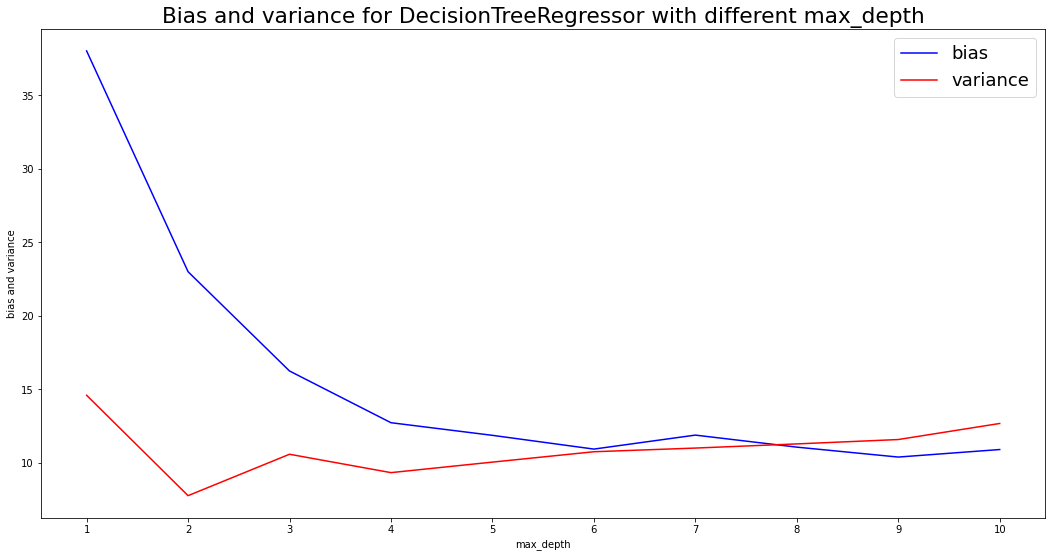

In [ ]:
plot_biase_variance(DecisionTreeRegressor(), 'max_depth', np.arange(1, 11), X, y, num_runs=100)

__4. (1 балл)__
Постройте бэггинг над всеми тремя моделями (линейная регрессия, решающее дерево, случайный лес). Вспомните обсуждение с лекции о том, во сколько раз в теории бэггинг уменьшает разброс базового алгоритма. Выполняется ли это в ваших экспериментах? Если нет, поясните, почему.

__Your answer here:__

### Визуализация предсказаний базовых алгоритмов бэггинга

В материалах лекций можно найти изображение, похожее на мишень - визуализация алгоритмов с разным смещением и разным разбросом. В центре "мишени" - правильный ответ, а "попадания" - предсказания алгоритмов, обученных по разным выборкам. Построим похожее изображение на наших данных для трех алгоритмов. Наши "мишени" будут одномерными, потому что мы решаем задачу одномерной регрессии.

__5. (2 балла)__

Реализуйте фукнцию plot_predictions. Она должна выполнять следующие действия:
1. Случайно выбрать num_test_objects пар объект-целевая переменная из выборки X, y. Получится две выборки: маленькая X_test, y_test (выбранные тестовые объекты) и X_train, y_train (остальные объекты).
1. Сгенерировать num_runs выборок методом бутстарапа из X_train, y_train. На каждой выборке обучить алгоритм regressor и сделать предсказания для X_test.
1. Нарисовать scatter-график. По оси абсцисс - объекты тестовой выборки (номера от 0 до num_test_objects-1), по оси ординат - предсказания. В итоге получится num_test_objects столбиков с точками. Для каждого тестового объекта надо отметить одним цветом все предсказания для него, а также черным цветом отметить правильный ответ.
1. Подпишите оси и название графика (аргумент title).

In [ ]:
notnan = np.vectorize(lambda x: not np.isnan(x))

def plot_predictions(regressor, X, y, num_runs=100, num_test_objects=10, title="", plot=plt):
    """
    plot graphics described above
    """


    l = X.shape[0]    
    test_choice = np.random.choice(l, num_test_objects)
    train_choice = np.setxor1d(range(l), test_choice)
    test_choice = np.setxor1d(range(l), train_choice)
    len_train, len_test = len(train_choice), len(test_choice)
    
    predictions = np.empty((l, num_runs))
    predictions[:] = None
    
    for i in range(num_runs):
        choice = np.random.choice(train_choice, len_train)
        mask = np.ones(l, dtype=bool)
        mask[choice] =  False
        regressor.fit(X[choice], y[choice])
        predictions[:, i][test_choice] = regressor.predict(X)[test_choice]
    
    xs = np.ndarray.flatten(np.repeat(np.expand_dims(range(len_test), axis=1), num_runs, axis=1))
    ys = predictions
    ys = np.ndarray.flatten(ys)
    ys = ys[np.where(notnan(ys))]
    plot.scatter(xs, ys, c='red')
    plot.scatter(range(len_test), y[test_choice], s=300, c='black', marker='x')
    plot.set(xticks=range(len_test), xticklabels=range(len_test))
    plot.set_title(title, size=15)

__6. (0 баллов)__

Нарисуйте графики для линейной регрессии, решающего дерева и случайного леса. Нарисуйте три графика в строчку (это можно сделать с помощью plt.subplot) с одинаковой осью ординат (это важно для понимания масштаба разброса у разных алгоритмов):

In [ ]:
lr = LinearRegression()
tree = DecisionTreeRegressor()
forrest = RandomForestRegressor(n_estimators=30)

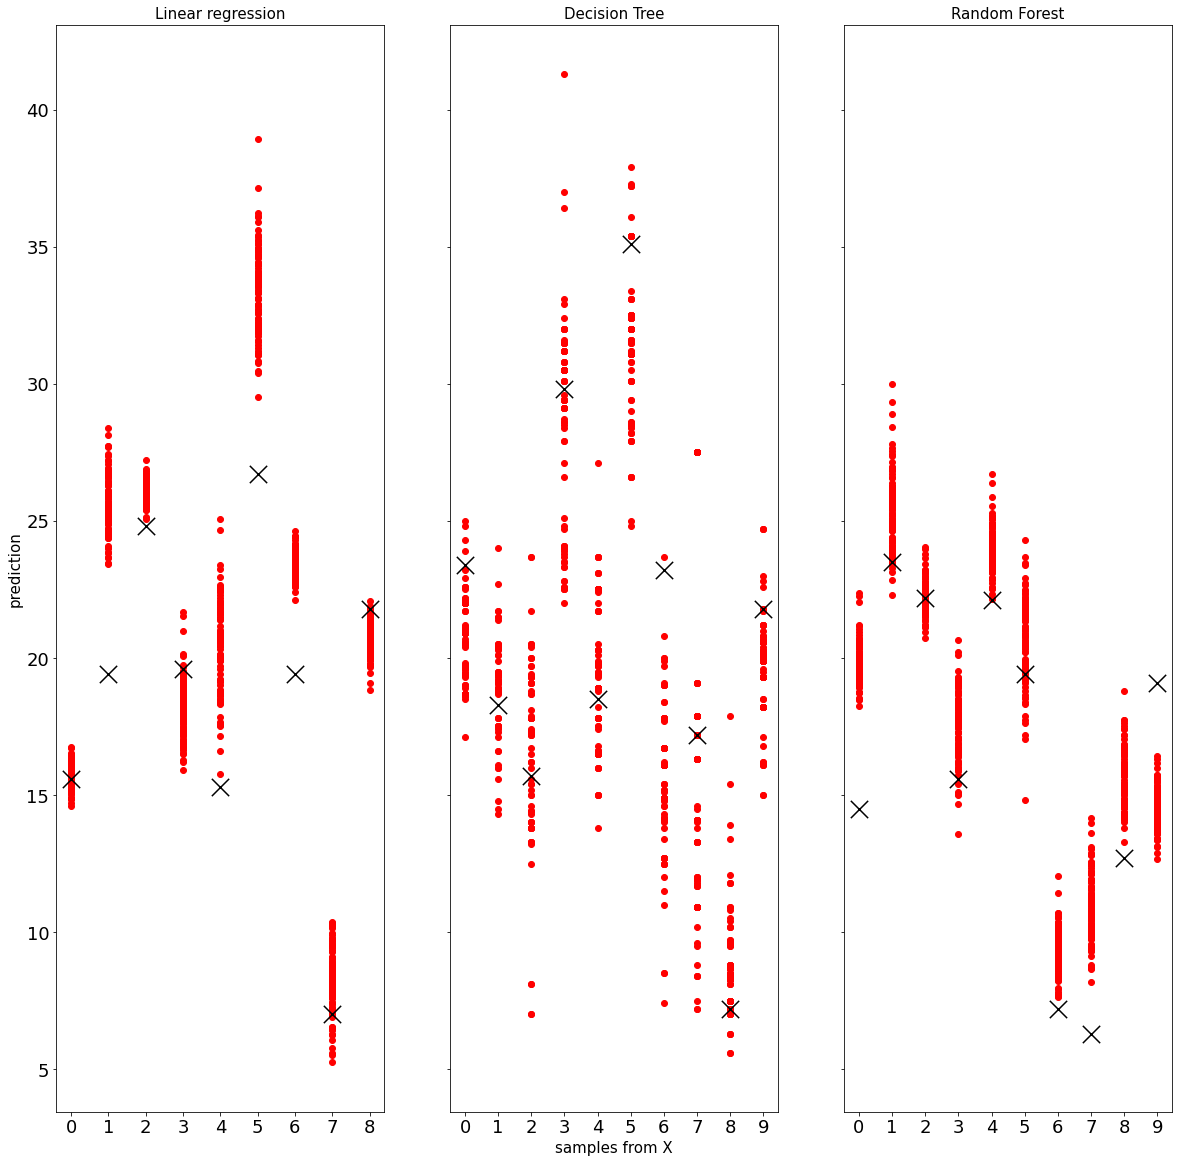

In [ ]:
f, axes = plt.subplots(1, 3, sharex = False, sharey=True, figsize=(20, 20))
plot_predictions(lr, X, y, title='Linear regression', plot=axes[0])
plot_predictions(tree, X, y, title='Decision Tree', plot=axes[1])
plot_predictions(forrest, X, y, title='Random Forest', plot=axes[2])

axes[1].set_xlabel('samples from X', size=15)
axes[0].set_ylabel('prediction', size=15)
plt.show()

__7. (1 балл)__

Для каждого графика прокомментируйте, как он характеризует смещение и разброс соответствующего алгоритма. 

__Your answer here:__ Как мы и предполагали (и посчитали)  ранее, у линейной регрессии разброс совсем небольшой, а смещение существенное.

У решающего дерева наибольший разброс на данной картинке. Неудивительно, деревья имеют тенденцию подгоняться под выбрку и усложняться, поэтому на разных обучающих выборках деревья обучаются очень по-разному. Отсюда большой разброс и не очень боьшое смещение (ответ часто попадает близко к середине интервала).

Решающий лес, как бэггинг над слабо коррелированными деревьями, имеет меньший разброс, чем дерево, при этом смещение его не страдает.

### Изменение bias и variance при изменении гиперпараметров

__8. (0 баллов)__

Постройте графики зависимости смещения и разброса от гиперпараметров решающего дерева max_depth (от 1 до 10) и max_features (от 1 до X.shape[1]):

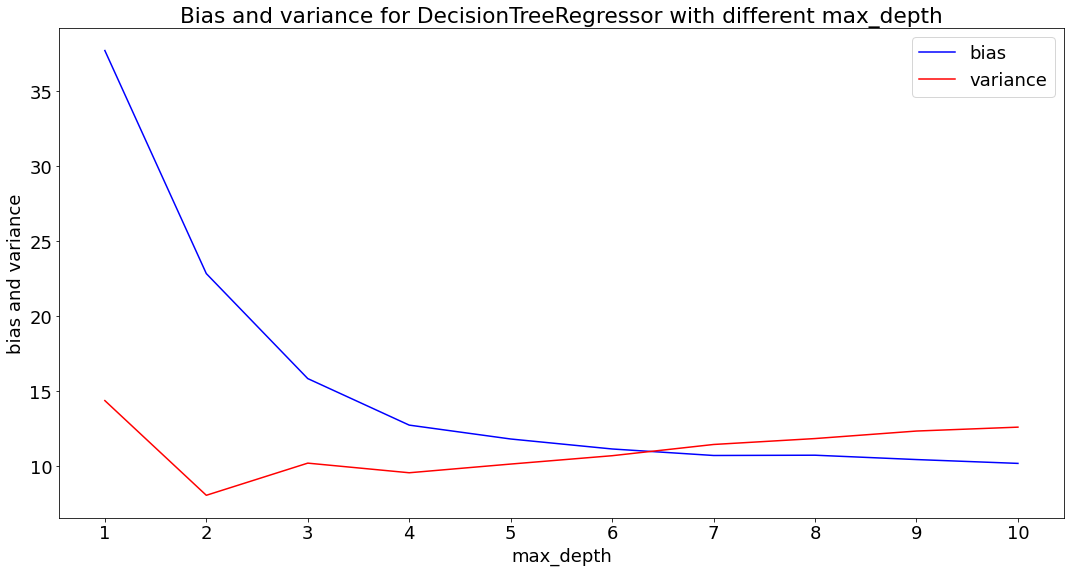

In [ ]:
plot_biase_variance(DecisionTreeRegressor(), 'max_depth', range(1, 11), X, y)

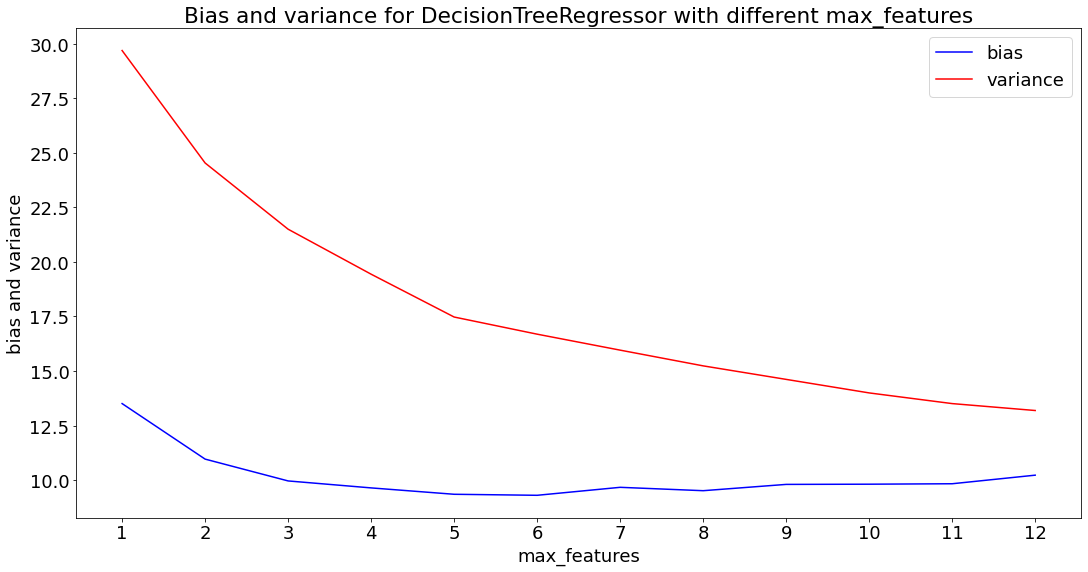

In [ ]:
plot_biase_variance(DecisionTreeRegressor(), 'max_features', range(1, X.shape[1]), X, y)

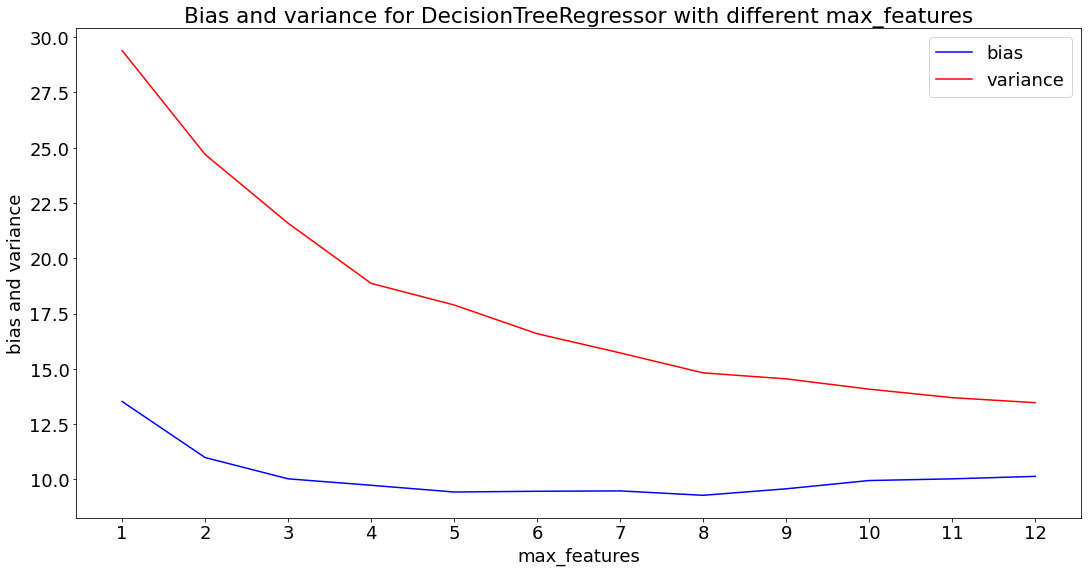

In [ ]:
plot_biase_variance(DecisionTreeRegressor(), 'max_features', range(1, X.shape[1]), X, y)

__9. (0 баллов)__

Постройте графики зависимости смещения и разброса от n_estimators (по сетке 2**np.arange(1, 10)) для случайного леса и градиентного бустинга:

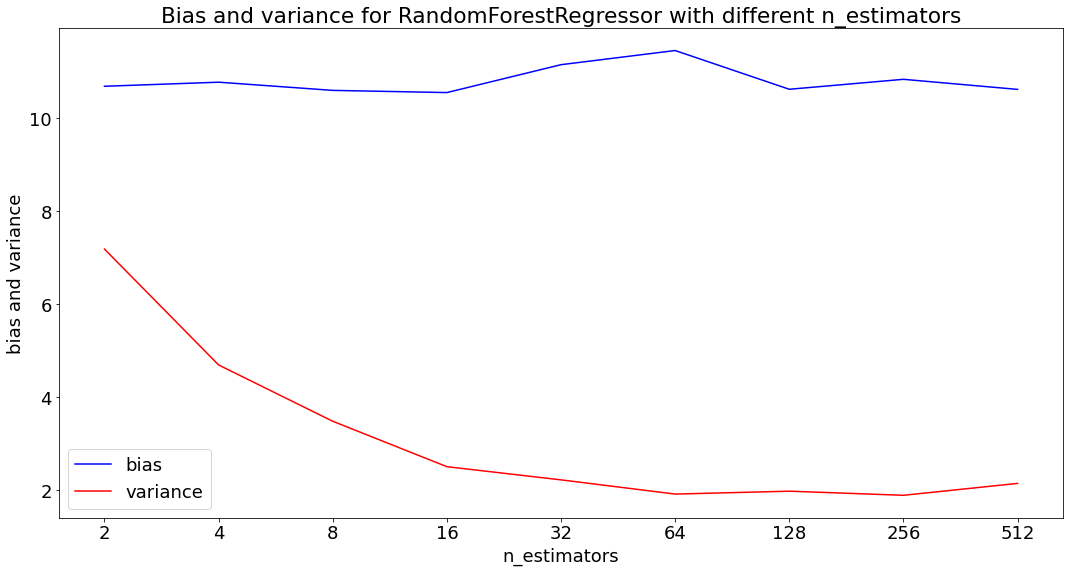

In [ ]:
plot_biase_variance(RandomForestRegressor(), 'n_estimators', 2**np.arange(1, 10), X, y, num_runs=30)

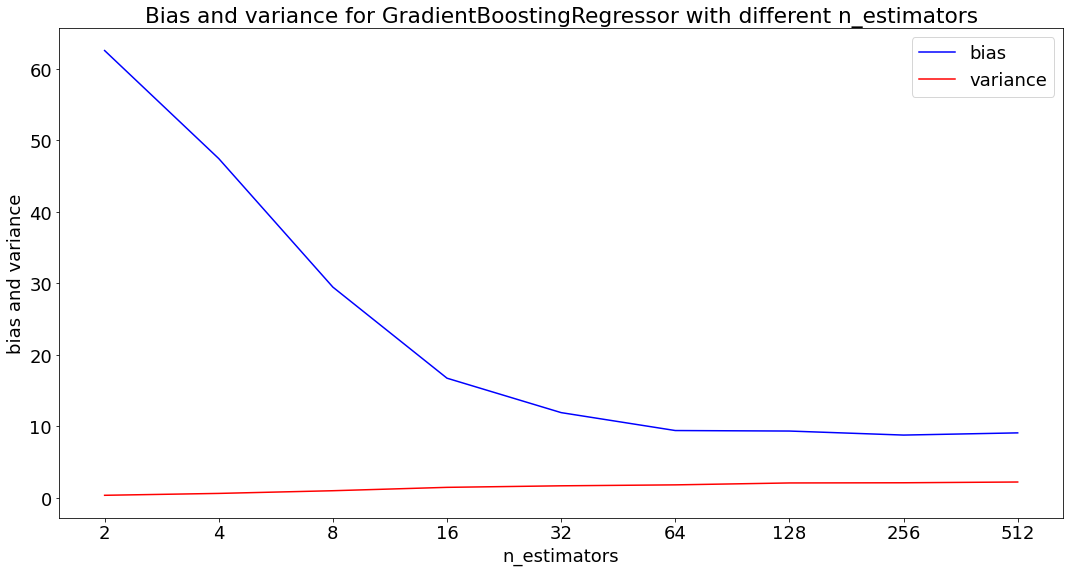

In [ ]:
plot_biase_variance(GradientBoostingRegressor(), 'n_estimators', 2**np.arange(1, 10), X, y, num_runs=50)

__10. (2 балла)__

Прокомментируйте графики (всего 4 графика): почему они имеют такой вид.

__Your answer here:__ 
#### Решающее дерево и max_depth

_В теории мы знаем, что как правило,
смещение маленькое у сложных семейств (например, у деревьев) и большое у простых
семейств (например, линейных классификаторов). Как правило, простые семейства имеют маленькую дисперсию, а сложные семейства — большую._

Как видно ниже, с усложнением дерева (с увеличением максимальной глубины) уменьшается смещение и увеличивается разброс.

#### Решающее дерево и max_features
В этом случае с ростом **max_features** дерево существенно не усложняется, а просто начинает дольше работать и качественнее разбивать выборку. Не усложняется - не меняется bias. Почему уменьшается variance? Потому что чем меньше **max_features**, тем больше разбиение в ноде зависит от выбора **max_features** штук признаков, по которым идет разбиение $\Rightarrow$ тем более разными получаются деревья. Значит, с увеливением **max_features** деревья начинают получаться более одинаковыми и variance уменьшается.

#### Решающий лес и n_estimators
Как мы уже говорили выше, при бэггинге смещение не меняется, а разброс при маленькой корреляции моделей уменьшается (в идеале - в количество раз, равное числу моделей). 
Все это мы можем наблюдать на графике: смещение не меняется (немного шумит), разброс стремительно уменьшается.
Достигается тем, что случайный лес как раз стремится делать деревья мало коррелированными.

#### Градиентный бустинг и n_estimators
Градиентый мощен и позволяет очень хорошо подстроиться под выборку. При увеличении количества моделей bias сильно уменьшается, так как подстроение под выборку начинает быть чрезвычайно точным.
Разброс в нашем случае начинает слегка (нам повезло) увеличивается в связи с переобучением бустинга с некоторого момента.

Среди всех рассмотренный вариантов у бустинга лучшие показатели по bias и variance в совокупности, что показывает его крутость.